# 합성곱-LSTM 적층 감성 분류기

이 노트북에서 합성곱 층 위에 LSTM을 쌓아 감성에 따라 IMDB 영화 리뷰를 분류합니다.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/dl-illustrated/blob/master/notebooks/11-9.conv_lstm_stack_sentiment_classifier.ipynb)

#### 라이브러리 적재

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### 하이퍼파라미터 설정

In [2]:
# 출력 디렉토리
output_dir = 'model_output/cnnLSTM'

# 훈련
epochs = 4
batch_size = 128

# 벡터 공간 임베딩
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# 합성곱 층 구조
n_conv = 64  
k_conv = 3 
mp_size = 4

# LSTM 층 구조
n_lstm = 64 
drop_lstm = 0.2

#### 데이터 적재

In [3]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

17464789/17464789 [==============================] - 1s 0us/step


#### 데이터 전처리

In [4]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### 신경망 만들기

In [5]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [6]:
# 양 방향으로 역전파되기 때문에 LSTM 층의 파라미터가 두 배가 됩니다.
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 198, 64)           12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                        

#### 모델 설정

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 훈련!

In [9]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 17s 24ms/step - loss: 0.4815 - accuracy: 0.7380 - val_loss: 0.3091 - val_accuracy: 0.8699
Epoch 2/4
196/196 [==============================] - 3s 18ms/step - loss: 0.2402 - accuracy: 0.9070 - val_loss: 0.3150 - val_accuracy: 0.8688
Epoch 3/4
196/196 [==============================] - 3s 18ms/step - loss: 0.1689 - accuracy: 0.9381 - val_loss: 0.3434 - val_accuracy: 0.8631
Epoch 4/4
196/196 [==============================] - 3s 18ms/step - loss: 0.1177 - accuracy: 0.9602 - val_loss: 0.4166 - val_accuracy: 0.8555


#### 평가

In [10]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [11]:
y_hat = model.predict(x_valid)

782/782 [==============================] - 4s 4ms/step


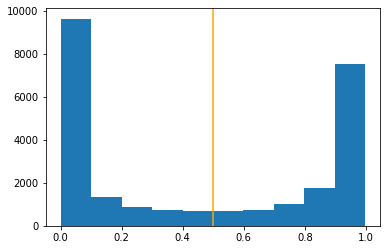

In [12]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [13]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.49'